# Event-Related Analyses

This is the **second** in a series of hands-on tutorials designed to teach neural data analysis. No programming background is necessary, but a familiarity with basic Python, linear algebra, and electrophysiology is helpful. This tutorial teaches event-related analyses using data from an experiment in our lab where *single-pulse electrical stimulation* (SPES) was used to map *cortico-cortical evoked potentials* (CCEPs); the same methods can also be used for analysis of *event-related potentials* (ERPs). The tutorial is implemented in a Google Colab notebook, so no local Python installation is required; see the `README.md` file for setup instructions.

### Objectives:
1. Review common types of event-related analysis (e.g., ERPs, CCEPs)
2. Understand how to setup event-related analyses by creating epochs
3. Gain experience with loading, reformatting, and subsetting data
4. Visualize CCEPs and extract relevant features for statistical analysis
5. **DIY**: Identify CCEPs that propagate as traveling waves

----
> Justin Campbell   
> justin.campbell@hsc.utah.edu  
> Version: 08-31-23

## Setup Notebook
Run this cell to install/import the libraries and packages used throughout.

In [1]:
# Install MNE
! pip install MNE

# Import libraries
import os
import mne
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import statsmodels.api as sm
from scipy.stats import ttest_ind
from IPython.display import YouTubeVideo

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Ignore warnings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# Improve figure quality
%matplotlib inline
%config InlineBackend.figure_format='retina'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 14.9 MB/s eta 0:00:00
Mounted at /content/drive


## Set Datapath
This tutorial uses sample data that needs to be downloaded from Google Drive. You can find the `Data` folder [here](https://drive.google.com/drive/folders/1ApD9cu3gtnUNT-zSg6OzQBV8wKWnUoep?usp=sharing).  
**To access the data, you'll need to change the `datapath` variable to match the path to your download of `Data`.** For example, my copy of `Data` is stored in a folder called `NDS-Workshops`, which is located within another folder called `INMAN Lab`; I've assigned my full path to the variable `datapath` below.

An easy way to get the full path is to:
1. Click the *Files* tab on the left menu bar
2. Navigate through the folders until you located `Data`
3. Click the dots next to the folder name
4. Select *Copy path*, and assign it to `datapath` below

In [2]:
datapath = '/content/drive/MyDrive/Code/INMAN Lab/NDS-Workshops/Data'

# Check whether path correctly entered
if os.path.exists(datapath):
  print('"Data" folder found!')
else:
  print('"Data" folder NOT found! Double-check the datapath.')

"Data" folder found!


## 0. Pre-Work
For context, I've included some basic information about two common types of event-related analyses: event-related potentials (ERPs) and cortico-cortico evoked potentials (CCEPs). Although their physiological origins are distinct, the same analysis methods can be applied to either type of event-related activity.

### 0.1 Cohen ERPs

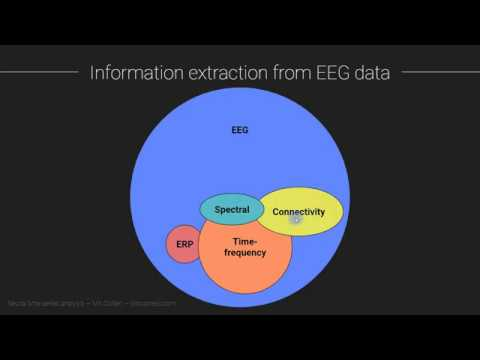

In [ ]:
YouTubeVideo('iFWrVzLYop0', width = 600, height = 400)

Key Points:
- An **event-related potential (ERP)** is a transient, measurable change in voltage resulting from a specific sensory, cognitive, or motor event
- ERPs can help us compare how specific brain regions respond differently to stimuli in the environment
- Information may be lost from time-domain averaging when dynamics are not phase locked

### 0.2 Cortico-Cortical Evoked Potentials (CCEPs)
**Cortical-cortical evoked potentials (CCEPs)** are electrophysiological responses to direct, single-pulse electrical stimulation at another site. The distribution and properties (e.g., amplitude) of the CCEPs observed allow researchers and clinicians to infer *causal* patterns of connectivity and information flow throughout the brain. An excellent review of CCEPs is available from [Keller et al. 2014](https://royalsocietypublishing.org/doi/10.1098/rstb.2013.0528?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed#d1e1252); the review discusses various approaches to mapping human brain networks with CCEPs, the electro-mechanistic basis of the CCEP, and considerations for analysis. Shown below is a sample CCEP, where the **N1** (10-50ms post-stimulation) and **N2** (50-400ms post-stimulation) components are highlighted.


<img src='https://drive.google.com/uc?id=1Nsjj3dNyIXdKydTzFisj5Wi63urPGZmd'>


Key Points:
- Single-pulse electrical stimulation may cause detectable perturbatations  (i.e., cortico-cortical evoked potentials, CCEPs)
- CCEPs provide insights into patterns of connectivity and information flow throughout the brain
- CCEP features capture distinct physiological processses (e.g., N1 = excitatory depolarization of pyramidal cells in deep cortical layers)

## 1. Setting Up an Event-Related Analysis
In the first tutorial, we covered neural signal processing and basic time- and frequency-domain analyses. Now, we'll shift our focus towards event-related analysis which allows us to characterize how signals are modulated by particular events of interest (e.g., presentation of an image, administration of electrical stimulation).  

To setup an event-related analysis, we need to convert continuous data into discrete **epochs**, a period of time marked by a clear start/end point. We start by outlining the epoch structure and then review two different ways of creating epochs.

### 1.1 Outline the Epoch Structure
Before writing any code for your data, I highly recommend sketching out (on paper) what you want your epochs to look like. Will you have one event in a single epoch, or several events? Are you interested in activity before and after the event occurs, or only the activity following the event? Are there particular times during the epoch that you need to ignore (e.g., peri-stimulation artifact)?  

Below, we simulate this process by coding-up a pseudo-sketch that has the following features:
- Event at time 0s
- Includes data 1s before event and 3s after
- Splits the post-event time into two equally sized blocks of 1.5s each

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


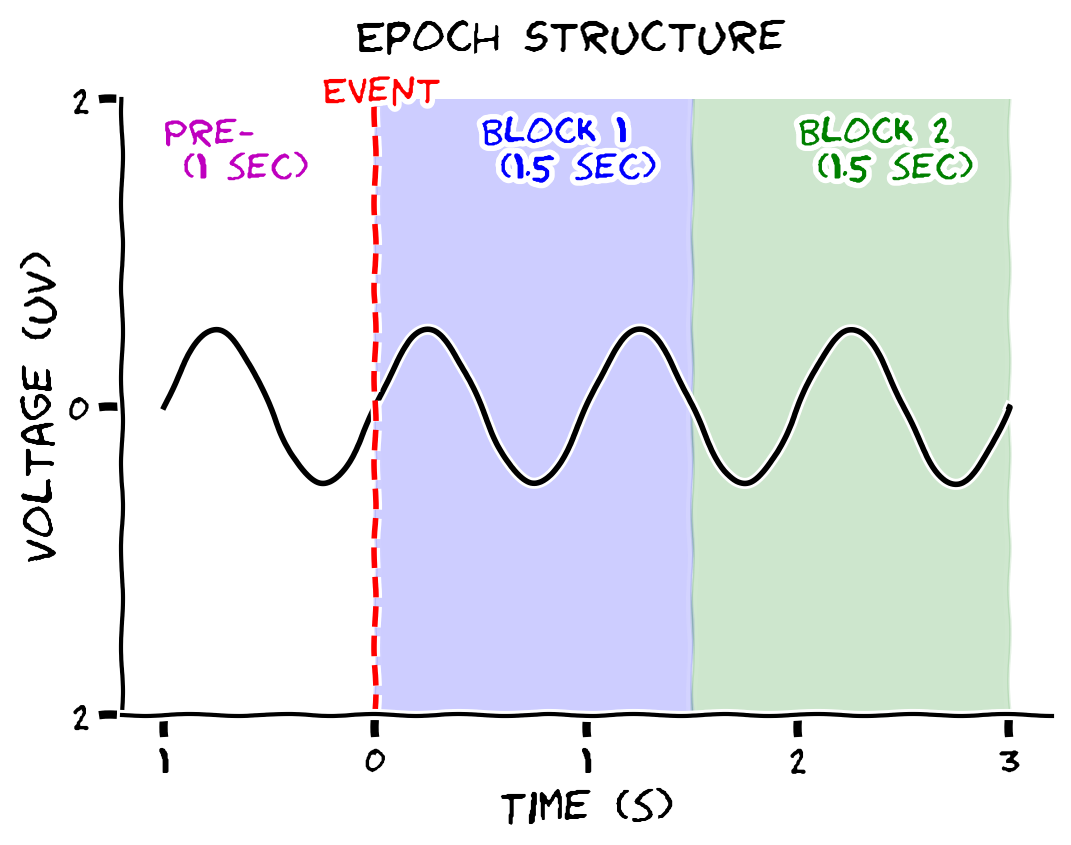

In [ ]:
# Simulate data
sketch_times = np.arange(start = -1, stop = 3, step = .0001)
sketch_data = 0.5 * np.sin(2 * np.pi * 1 * sketch_times)

# Generate sketch
with plt.xkcd(): # makes it look hand-drawn
  fig, ax = plt.subplots(1, 1, figsize = (6,4))
  plt.plot(sketch_times,sketch_data, color = 'k')

  # Add dotted lines and shaded rectangles
  plt.axvline(0, linestyle = '--', color = 'r')
  plt.axvspan(xmin = 0, xmax = 1.5, ymin = -2, ymax = 2, color = 'b', alpha = 0.1)
  plt.axvspan(xmin = 1.5, xmax = 3, ymin = -2, ymax = 2, color = 'g', alpha = 0.1)

  # Add labels
  plt.text(x = -1, y = 1.5, s = 'Pre- \n (1 sec)', color = 'm')
  plt.text(x = -0.25, y = 2, s = 'Event', color = 'r')
  plt.text(x = 0.5, y = 1.5, s = 'Block 1 \n (1.5 sec)', color = 'b')
  plt.text(x = 2, y = 1.5, s = 'Block 2 \n (1.5 sec)', color = 'g')

  # Clean-up appearance
  plt.suptitle('Epoch Structure')
  plt.xticks([-1,0,1,2,3])
  plt.yticks([-2,0,2])
  plt.ylim([-2,2])
  plt.xlabel('Time (s)', fontsize = 'large')
  plt.ylabel('Voltage (uV)', fontsize = 'large')
  sns.despine(top = True, right = True)

plt.show()

### 1.2 Create Epochs Manually
To manually create epochs, we'll first need to decide what to consider the "0" point. Let's imagine that we performed an experiment where participants were shown a series of images. Our goal is to analyze the brain activity around the time in which images were presented on screen. To track whenever an image came on screen, we decided to mark that time point as an event. If the goal is to create an epoch centered around that event, we can find the time at which those events occured, and crop the data around it.  

Let's first load our sample dataset (`Baseline.csv`) and display it to see the overall structure.

In [ ]:
# Load Baseline.csv
sample_data = pd.read_csv(os.path.join(datapath, 'Baseline.csv'), header = None) # time x channel
sample_chans = ['Chan' + str(i+1) for i in range(sample_data.shape[1])] # create dummy channel labels (e.g., Chan1, Chan2,...)
sample_data.columns = sample_chans
fs = 2000 # sampling frequency (Hz)

sample_data

,Chan1,Chan2,Chan3,Chan4,Chan5,Chan6,Chan7,Chan8,Chan9,Chan10,...,Chan81,Chan82,Chan83,Chan84,Chan85,Chan86,Chan87,Chan88,Chan89,Chan90
0,-459,-338,-5,-71,150,137,-49,26,-1182,-153,...,29,-14,10,213,26,-533,69,80,262,129
1,-493,-376,-8,-65,152,144,-28,34,-1221,-157,...,12,-21,17,214,39,-531,61,66,245,126
2,-523,-391,-6,-59,151,154,-6,49,-1262,-160,...,-6,-27,23,213,56,-533,60,55,229,118
3,-530,-383,3,-49,159,171,20,64,-1286,-146,...,-22,-27,24,210,68,-534,61,53,218,114
4,-535,-394,12,-42,166,193,42,78,-1291,-129,...,-39,-23,14,206,72,-530,53,62,213,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59990,-142,-153,-81,83,204,228,215,153,-162,-11,...,9,-18,97,-48,45,-206,64,59,232,147
59991,-151,-174,-90,81,183,193,210,136,-205,-26,...,7,-12,81,-85,25,-195,59,45,234,138
59992,-165,-179,-100,81,168,161,192,113,-245,-40,...,-2,-8,64,-114,-5,-174,54,29,232,132
59993,-172,-176,-108,69,149,134,163,86,-283,-58,...,-9,-13,52,-133,-33,-158,47,16,223,130


The data appears to be organized as *samples x channels* based on the dimensions printed below the table (i.e., 59995 rows x 90 columns). Note that the data itself doesn't show units, so it's very important to know exactly what was recorded (in our case the values represent voltage in microvolts/uV).  

Next, we'll simulate events by creating an array of 0's (no event / no image presented) and 1's (event / image presented). By creating an array of events (`sample_events`) that is the same length as `sample_data`, we make it easier to crop our data into epochs.

In [ ]:
# Simulate events
sample_events = np.zeros(len(sample_data)) # create array of zeros same length as baseline
sample_events[(fs*3)::(fs*3)] = 1 # make an event every 3s starting 3s into the recording
event_idxs = np.squeeze(np.where(sample_events == 1)) # find where value = 1

# Create epochs (± 1s around event)
sample_epochs = []
for i in event_idxs:
  i_epoch = np.arange(start = (i-fs), stop = (i+fs))
  sample_epochs.append(i_epoch)

Now we can use the `pd` method `.iloc()`, which allows you to parse the rows/columns of a `pd.DataFrame()` by providing the indices of interest (as an integer). Here, we loop through the epochs we've created, parse the data related to that epoch, and separately plot each trace of the data on the same figure.

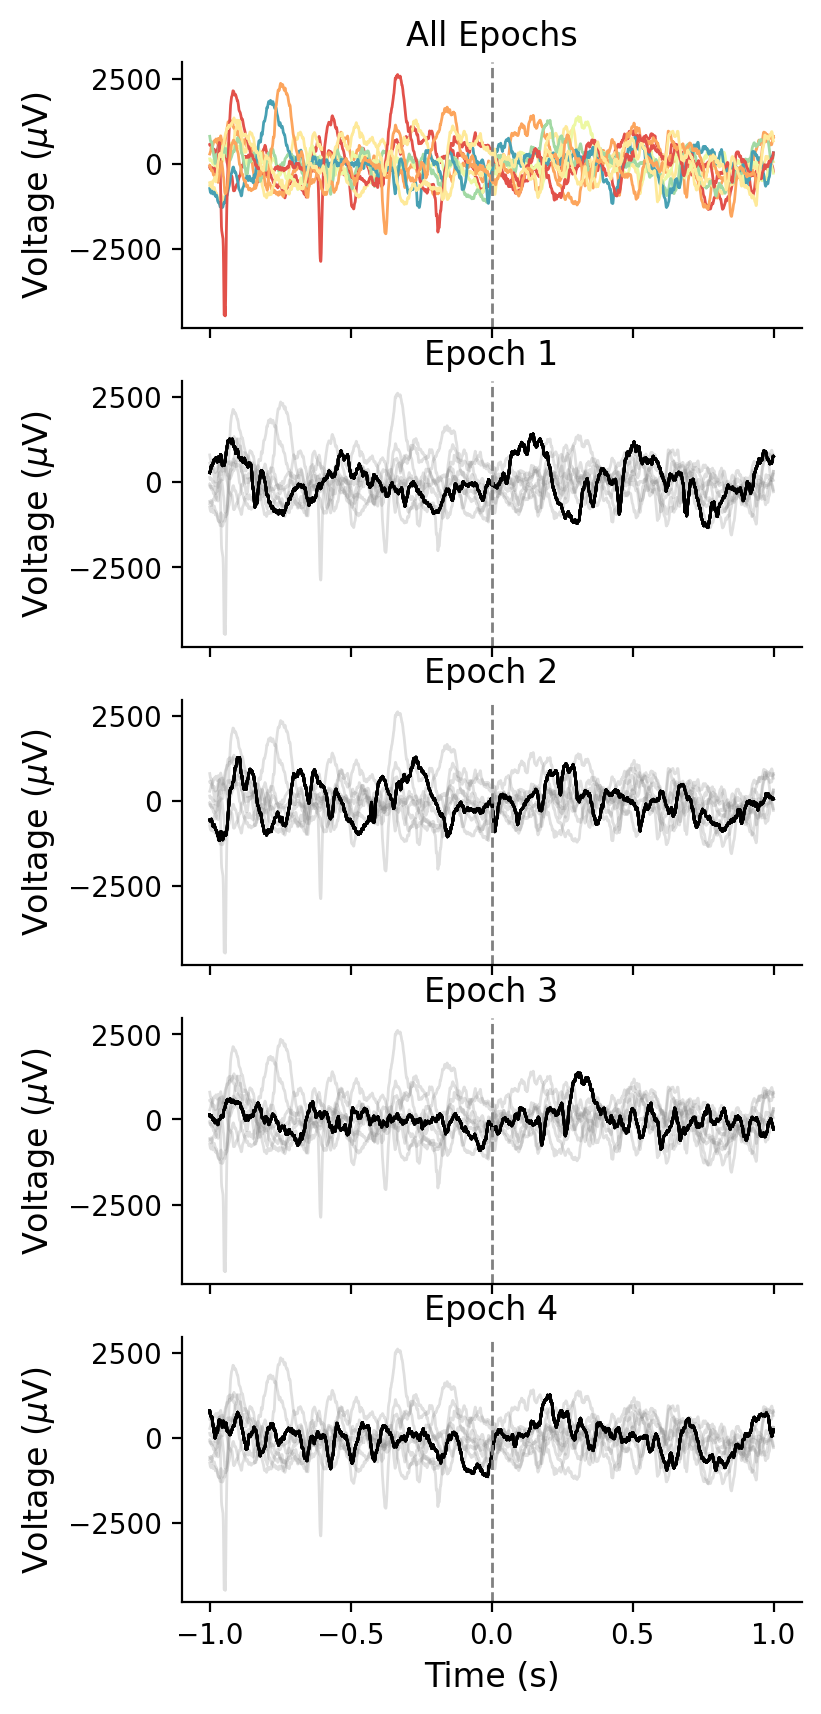

In [ ]:
# Figure params
sns.set_palette('Spectral')
fig, axes = plt.subplots(5, 1, figsize = (4,10), sharex = True)
epoch_times = np.arange(start = -fs, stop = fs) / fs # array of times ranging from -1s to 1s

# Plot data across epochs on top, accentuate first 3 epochs below
for i in range(len(axes)):
  for ii in sample_epochs:
    if i == 0: # if its the first axis, plot all epochs overlaid
      axes[i].plot(epoch_times, sample_data.iloc[ii,0], linewidth = 1)
      axes[i].set_title('All Epochs')
    elif i > 0: # otherwise emphasize data from a single epoch
      axes[i].plot(epoch_times, sample_data.iloc[ii,0], color = 'grey', linewidth = 1, alpha = 0.25)
      axes[i].plot(epoch_times, sample_data.iloc[sample_epochs[i],0], color = 'k', linewidth = 1)
      axes[i].set_title('Epoch %s' %str(i))

  # Clean-up figure appearance
  axes[i].axvline(0, linestyle = '--', linewidth = 1, color = 'grey')
  axes[i].set_ylabel('Voltage ($\mu$V)', fontsize = 'large')
  axes[i].set_yticks([-2500, 0, 2500])
  axes[-1].set_xlabel('Time (s)', fontsize = 'large')
  sns.despine(top = True, right = True)

### 1.3 Create Epochs from Events in `MNE`
An alternative approach is to leverage functionality within `MNE` to construct epochs. `MNE` has an object class (`mne.Epoch`) explicitly for this purpose. Detailed documentation on how to segment continuous data into epochs can be found [here](https://mne.tools/stable/auto_tutorials/epochs/10_epochs_overview.html#sphx-glr-auto-tutorials-epochs-10-epochs-overview-py).  

Below, we create `MNE.info` and `MNE.raw` objects which allows us to use the built-in `MNE` functions.

In [ ]:
num_seeg_chans = sample_data.shape[1] # number of columns

# Add column for Stim (event) channel
sample_data['Stim'] = sample_events

# Metadata for MNE.info object
sample_ch_types = (['seeg'] * num_seeg_chans) + ['stim'] # define channel types (e.g., SEEG, Stim)

# MNE objects
sample_info = mne.create_info(ch_names = sample_data.columns.to_list(), ch_types = sample_ch_types, sfreq=fs)
sample_raw = mne.io.RawArray(sample_data.T, sample_info)

Creating RawArray with float64 data, n_channels=91, n_times=59995
    Range : 0 ... 59994 =      0.000 ...    29.997 secs
Ready.


We can use the built-in method `mne.find_events()` to highlight when our events occured.

In [ ]:
sample_events_mne = mne.find_events(sample_raw, stim_channel="Stim")
sample_events_mne

9 events found
Event IDs: [1]


array([[ 6000,     0,     1],
       [12000,     0,     1],
       [18000,     0,     1],
       [24000,     0,     1],
       [30000,     0,     1],
       [36000,     0,     1],
       [42000,     0,     1],
       [48000,     0,     1],
       [54000,     0,     1]])

Now we can use the `sample_events_mne` variable we created, to define our epochs. Note that we can specify the time range we want to crop around the event; here I set `tmin = -1` and `tmax = 1` to add ± 1s around the event.  

Similar to above, let's use this data to plot all epochs for a single channel.

Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 9 events and 4001 original time points ...
0 bad epochs dropped


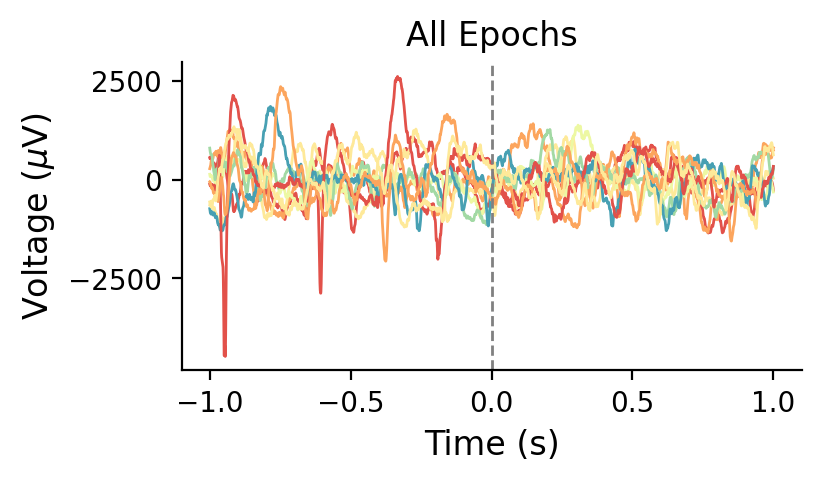

In [ ]:
# Create epochs around events (± 1s)
sample_epochs_mne = mne.Epochs(sample_raw, sample_events_mne, tmin=-1, tmax=1, preload = True, baseline = None)

# Plot data across epochs
fig, axes = plt.subplots(1, 1, figsize = (4,2))
for i in range(len(sample_epochs_mne)):
  plt.plot(sample_epochs_mne.times, sample_epochs_mne.get_data()[i,0,:], linewidth = 1)

# Clean-up figure appearance
plt.axvline(0, linestyle = '--', linewidth = 1, color = 'grey')
plt.title('All Epochs')
plt.ylabel('Voltage ($\mu$V)', fontsize = 'large')
plt.xlabel('Time (s)', fontsize = 'large')
plt.yticks([-2500, 0, 2500])
sns.despine(top = True, right = True)

As you've seen, you can create epochs using either method, with identical results. Nothing appears to happen around the event we defined, which isn't surprising as we arbitrarily created epochs around random points in the recording.

Next, we'll load some pre-epoched data to investigate responses evoked by electrical stimulation.

## 2. The CCEP Dataset

For this rest of this tutorial, we'll be working with a curated dataset of human intracranial recordings (`CCEPDataset.mat`). The neural data was collected from an experiment where brief pulses of monopolar electrical stimulation were used to evoke *cortico-cortical evoked potentials* (CCEPs). At the University of Utah, we routinely perform CCEP experiments to map the connections between different brain areas.



### 2.1 Data Importing
In a perfect world, your data would be beautifully organized and easy to analyze. However, that is rarely ever the case. A major component of neural data science is re-organizing, re-formatting, and cleaning up the data in order to structure it in a more usable form.  

The dataset we'll use is a `.mat` (`MATLAB`) file, which contains experiment information saved as separate variables. There are tools for reading in files of various common data formats (e.g., `.mat`, `.csv`, `.xlxs`) as well as those specific to neural recording systems (e.g., `.edf`, `.nsx`). This allows for *interoperability*, the ability to switch between two programming languages (e.g., `MATLAB` &#8594; `Python`).

If we were to load the `.mat` file in `MATLAB`, we would see the following variables:
- `num_chans`: number of channels in recording
- `num_trials`: number of single-pulse electrical stimulation (SPES) trials
- `fs`: sampling rate (Hz)
- `trial_stim_chan`: index of channel stimulated
- `valid_resp_chans`: channels where ≥1 robust CCEPs were observed
- `pre_raw`: epoched pre-stim neural data
- `post_raw`: epoched post-stim neural data
- `pre_time`: pre-stim times (ms)
- `post_time`: post-stim times (ms)
- `prepro_params`: details about how the data was preprocessed

Below, we use the function `scipy.io.loadmat()` which allows us to read in `.mat` files as a `Python` dictionary.

In [ ]:
CCEP_dataset = scipy.io.loadmat(os.path.join(datapath, 'CCEPDataset.mat'), simplify_cells = True)
CCEP_dataset.keys() # display names of variables (keys in dictionary)

dict_keys(['__header__', '__version__', '__globals__', 'fs', 'num_chans', 'num_trials', 'post_data', 'post_time', 'pre_data', 'pre_time', 'prepro_params', 'trial_stim_chan', 'valid_resp_chans'])

Now that the dataset is loaded in, we can unpack it by creating variables to represent what was stored in the `.mat` file.

In [ ]:
fs = CCEP_dataset['fs']
num_chans = CCEP_dataset['num_chans']
num_trials = CCEP_dataset['num_trials']
post_data = CCEP_dataset['post_data']
pre_data = CCEP_dataset['pre_data']
post_time = CCEP_dataset['post_time']
pre_time = CCEP_dataset['pre_time']
trial_stim_chan = CCEP_dataset['trial_stim_chan']
valid_resp_chans = CCEP_dataset['valid_resp_chans']
prepro_params = CCEP_dataset['prepro_params']

# Display output
print('Sampling Rate: %sHz' %fs)
print('# Channels: %s' %num_chans)
print('# Trials SPES: %s' %num_trials)
print('Preprocessing Parameters: %s' %prepro_params)

Sampling Rate: 1000Hz
# Channels: 80
# Trials SPES: 1350
Preprocessing Parameters: Raw data, ~2s pre-/post-epochs (excluding 10ms peri-stim)


Finally, we can print the dimensions of our raw neural data (`preRaw` and `postRaw`) to see how they are organized.

In [ ]:
print(pre_data.shape)
print(post_data.shape)

(1996, 1350, 80)
(1996, 1350, 80)


Because we know that `nChans = 80` and `nTrials = 1350`, we can infer that the 1st dimension represents samples. Thus, `preRaw` and `postRaw` are structured as samples x trials x channels, and both share the same dimensions.

### 2.2 Characterizing the Dataset
Now that the data is reformatted, we can characterize what happened in the experiment. Let's create the following variables:
- `stim_counter`: stores how many times each individual channel in the dataset was stimulated.
- `stim_channels`: list of channels that were stimulated
- `stim_frac`: % of total channels that were stimulated
- `CCEP_chan_frac`: % of the total channels that had ≥1 CCEP

As is often the case with code, there are many different ways to solve a particular problem. In the code cell below, I walk through one approach to creating the `stim_counter` and `stim_channels` variables, but the approach is very inefficient.


In [ ]:
# Create a dictionary to store keys and values
stim_counter = {}

# Loop through list of trials
for i in trial_stim_chan:
  if i in stim_counter.keys(): # if there's already a key for that channel, add 1
    stim_counter[i] += 1
  else: # otherwise create a key, set the value to 1
    stim_counter[i] = 1

# Create list of stim channels
stim_chans = stim_counter.keys()

# Display dictionary
stim_counter

{4: 50,
 10: 50,
 20: 50,
 15: 50,
 7: 50,
 25: 50,
 14: 50,
 11: 50,
 23: 50,
 12: 50,
 3: 50,
 22: 50,
 6: 50,
 27: 50,
 13: 50,
 5: 50,
 1: 50,
 26: 50,
 2: 50,
 9: 50,
 19: 50,
 24: 50,
 21: 50,
 18: 50,
 16: 50,
 8: 50,
 17: 50}

There's a much more elegant approach that involves the [`np.unique()`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) function. Try reading the documentation and implementing this approach yourself below.

In [ ]:
# Alternative approach:


Using the information you have available, create the variables `stim_frac` and `CCEP_chan_frac`, to represent the fraction of channels that were stimulated (as a % of the total) and the fraction of channels with ≥1 robust CCEP, respectively. You may find the [`len()`](https://www.geeksforgeeks.org/python-len-function/) function useful here.

In [ ]:
# Calculate stim_frac and CCEP_chan_frac


# Uncomment the code below when you've calculated stim_frac and CCEP_chan_frac
# print('Channels stimulated: %s%%' %stim_frac)
# print('Channels with ≥1 CCEP: %s%%' %CCEP_chan_frac)

### 2.3 Parsing the Dataset
Suppose our goal was to focus only on a subset of the data to isolate a feature in a particular region of interest. What we'd like to do is create a new dataset that only includes the **5-500ms after stimulation** from trials where we **stimulated channel 2**, and only include **responses from channels 51-53 & 61-63**. This workflow mimics running a focal analysis of connectivity in a particular region (e.g., stimulating the amygdala and only being interested in CCEPs from contacts in the hippocampus).

Below, we'll use boolean indexing to create a new dataset: `subset_CCEPs`. Note that the indices are shifted because `Python` uses 0-indexing.

In [ ]:
# Define time-range
t_range = np.arange(0, 495) # 5 - 500ms (post_data starts at 5ms)

# Response chans of interest (indices)
hip_resp_chans = [50, 51, 52, 60, 61, 62]

# Find trials where the amygdala chans were stimulated
amy_stim_chans = [2]
amy_stim_trials = []
for idx, val in enumerate(trial_stim_chan):
  if val in amy_stim_chans:
    amy_stim_trials.append(idx)

# Subset post_data (display dimensions after each step)
print('(samples x trials x channels) \n')

print('Original dimensions: ', post_data.shape)
subset_CCEPs = post_data[t_range,:,:]
print('After subsetting samples/time: ', subset_CCEPs.shape)
subset_CCEPs = subset_CCEPs[:,amy_stim_trials,:]
print('After subsetting trials: ', subset_CCEPs.shape)
subset_CCEPs = subset_CCEPs[:,:,hip_resp_chans]
print('After subsetting response channels: ', subset_CCEPs.shape)

(samples x trials x channels) 

Original dimensions:  (1996, 1350, 80)
After subsetting samples/time:  (495, 1350, 80)
After subsetting trials:  (495, 50, 80)
After subsetting response channels:  (495, 50, 6)


By displaying the dimensions above, we can see that we've subset our dataset correctly. There are now:
- 495 samples for time (5-500ms)
- 50 trials (1 channel stimulated 50x)
- 6 response channels

## 3. Analyzing Event-Related Data
In this section, we'll review a basic workflow for analyzing CCEPs that includes detection, feature extraction, vizualization, and statistical comparison. Although the focus here is on CCEP analyses, many event-related analyses involve similar approaches. Therefore, the methods below can be used interchangeable whether the change in neural activity is endogenously (e.g., ERP) or exogenously generated.

### 3.1 Detection of Robust CCEPs
Not all responses to stimulation are considered robust. Although there is no standard criteria for detection of CCEPs, one common practice is to set a threshold (usually voltage), and classify the responses which exceed that threshold as "significant"/"robust". Many studies **z-score** the responses relative to some pre-stimulation baseline, which provides a normalized measure of how much the response differs from that baseline.  

In line with other studies, we'll define CCEPs as responses to stimulation which have a voltage that is 5 SDs above the average of the baseline period. To z-score the data, we use the following formula:

$$z = \frac{x - \mu}{\sigma}$$

Where,
- x = voltage (of post-stimulation response)
- ${\mu}$ = mean (of baseline)
- ${\sigma}$ = standard deviation (of baseline)

What we'd like to do is create a variable, `is_CCEP`, which stores whether the response in each channel to a given stimulation trial is a robust CCEP. Our final output will be a list of lists which store boolean (i.e,. `True/False` = 1/0) values which we can use to subset our data. We'll start by z-scoring each trial separately, and then using the trial-averaged responses to determine whether the CCEP meets our criteria.

In [ ]:
# Get baseline (pre_data) values corresponding to our data subset
baselines = pre_data[-495:, :, :] # subset time
baselines = baselines[:, amy_stim_trials, :] # subeset trials
baselines = baselines[:, :, hip_resp_chans] # subset channels

# Calculate baseline means and SDs (specify axis = 0 to compute over time/1st dim)
baseline_means = np.mean(baselines, axis = 0)
baseline_SDs = np.nanstd(baselines, axis = 0)

# Z-score data
CCEPs_Z = (subset_CCEPs - baseline_means) / baseline_SDs

# Average over trials
TA_CCEPs = np.mean(subset_CCEPs, axis = 1)
TA_CCEPs_Z = np.mean(CCEPs_Z, axis = 1)

# Determine which CCEPs meet criteria
is_CCEP = []
for i in range(TA_CCEPs_Z.shape[1]): # for each response channel
  if (TA_CCEPs_Z[:,i].min() <= -5) or (TA_CCEPs_Z[:,i].max() >= 5): # check if Z score exceeds ± 5 SDs
    is_CCEP.append(1) # True
  else:
    is_CCEP.append(0) # False

is_CCEP

[1, 1, 1, 0, 0, 0]

### 3.2 Extracting Features from CCEPs
Canonically, CCEPs are divided into two separate components: **N1** (\~10-50ms) and **N2** (\~50-400ms). Researchers have previously tracked the peak amplitude and latency of the N1/N2 components in order to characterize CCEPs throughout the brain. Below, we calculate the N1 component in the robust CCEPs we identified.

In [ ]:
# Define windows for N1 components
N1_win = np.arange(5, 45)   # 10-50ms

# Subset data by component time
TA_N1_data = TA_CCEPs[N1_win, :]

# Use np.argmin to find index of minimum values
TA_N1_indices = np.argmax(TA_N1_data, axis = 0)

# Display N1s
for i in range(len(hip_resp_chans)):
  # Check whether chan had robust CCEPs
  if is_CCEP[i] == 1:
    # Get channel name, N1 values, and N1 times
    sample_chan = hip_resp_chans[i]
    sample_N1_val = TA_N1_data[TA_N1_indices[i], i]
    sample_N1_time = N1_win[TA_N1_indices[i]]
    print('The N1 peak for Chan %s is %.1f (uV), which occured at %.1f ms' %(sample_chan, sample_N1_val, sample_N1_time))

The N1 peak for Chan 50 is 83.3 (uV), which occured at 36.0 ms
The N1 peak for Chan 51 is -103.1 (uV), which occured at 44.0 ms
The N1 peak for Chan 52 is -84.2 (uV), which occured at 5.0 ms



### 3.3 Visualizing CCEPs
Now that we've identified robust CCEPs and extracted relevant features, we can visualize the evoked responses. This step also serves as a sanity-check to ensure that what we've identified as the N1 components, matches our prior expectations. Below, we'll create figures which represent the data in different styles.

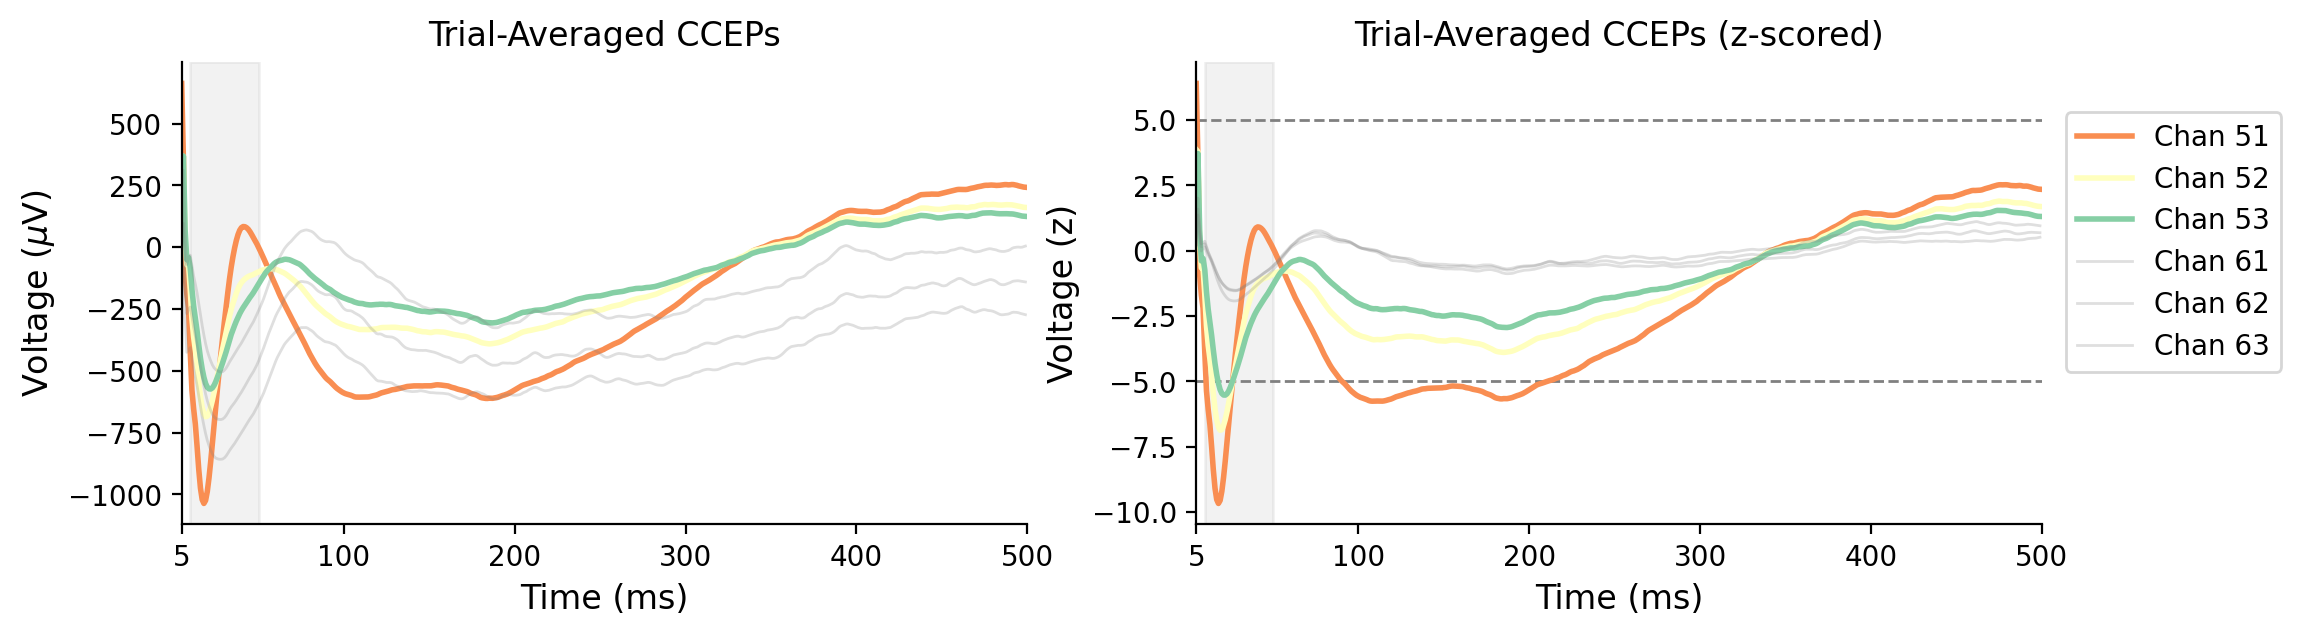

In [ ]:
# Figure parameters
fig, axes = plt.subplots(1, 2, figsize = (12,3))
palette = sns.color_palette('Spectral', n_colors = sum(is_CCEP))
color_idx = 0
times = np.arange(5, 500)

# Plotting
for i in range(len(is_CCEP)): # for each response channel
  if is_CCEP[i] == 1:
    axes[0].plot(times, TA_CCEPs[:,i], color  = palette[color_idx], linewidth = 2, label = ('Chan ' + str(hip_resp_chans[i]+1)))
    axes[1].plot(times, TA_CCEPs_Z[:,i], color  = palette[color_idx], linewidth = 2, label = ('Chan ' + str(hip_resp_chans[i]+1)))
    color_idx += 1
  else:
    axes[0].plot(times, TA_CCEPs[:,i], color  = 'grey', linewidth = 1, label = ('Chan ' + str(hip_resp_chans[i]+1)), alpha = 0.25)
    axes[1].plot(times, TA_CCEPs_Z[:,i], color  = 'grey', linewidth = 1, label = ('Chan ' + str(hip_resp_chans[i]+1)), alpha = 0.25)

# Clean-up figure appearance
axes[0].set_title('Trial-Averaged CCEPs')
axes[1].set_title('Trial-Averaged CCEPs (z-scored)')
axes[1].legend(loc = 'lower right', fontsize = 'medium', bbox_to_anchor = (1.3, 0.3))
axes[0].set_ylabel('Voltage ($\mu$V)', fontsize = 'large')
axes[1].set_ylabel('Voltage (z)', fontsize = 'large')
for ax in [axes[0], axes[1]]:
  ax.axvspan(xmin = 10, xmax = 50, alpha = 0.1, color = 'grey', zorder = -10)
  ax.set_xlabel('Time (ms)', fontsize = 'large')
  ax.set_xticks([5, 100, 200, 300, 400, 500])
  ax.set_xlim(5, 500)
axes[1].axhline(-5, lw = 1, linestyle = '--', color = 'grey', zorder = -5)
axes[1].axhline(5, lw = 1, linestyle = '--', color = 'grey', zorder = -5)
sns.despine(top = True, right = True)

Comparing the two plots highlights an important aspect of why z-scoring your data may be helpful. If we were to look at just the voltage values on the left plot, it would appear that several of the grey traces (CCEPs that did not meet our criteria for being "robust") have greater N1 peaks than those which did meet our criteria (the N1 window is shaded in grey). However, when we z-score the data using the pre-stimulation baseline, we can see that there actually wasn't a significant change in those channels pre- to post!  

Also, note how the CCEP shape/waveform is somewhat different across channels, and each of the responses has a different appearance to the canonical CCEP shown above. For example, none of these channels appear to show a robust N2 peak, which is more clear in the canonical CCEP. Given this variability, some have argued that we shouldn't search specifically for N1/N2 components, and that we should instead consider characterize the overall response shape (see [Miller et al., 2021](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008710)).

### 3.4 Statistical Comparison of CCEPs
The final step for our CCEP analysis is to determine whether there exists a statistically significant difference in the N1 component between channels. Here, we need to carefully consider our *a priori* research question in order to constrain our statistical analyses.  

Suppose we wanted to determine if both the N1 amplitude and latency were different between any given pair of channels. If we ran these two statistical analyses for all possible pairwise channel combinations, we would be conducting $2^{80}$ = 1,208,925,819,614,629,174,706,176 statistical comparisons!

With each additional test, we increase the likelihood of detecting a false-positive result.  To mitigate this, we'll focus our attention on two channels of interest: **Chan 51** and **Chan 53**. From the figure above, it looks as though there is a difference in the N1 amplitude between channels, so let's test whether a significant difference actually exists.  

First, let's compute the N1 peaks for each trial within our two channels of interest and convert those values to a `pd.DataFrame` to facilitate easier visualization.

In [ ]:
# Get indices of channels 51 & 53
chan51_idx = hip_resp_chans.index(50)
chan53_idx = hip_resp_chans.index(52)

# Subset to get channel data
chan51_data = subset_CCEPs[N1_win, :, chan51_idx]
chan53_data = subset_CCEPs[N1_win, :, chan53_idx]

# Calculate the N1 peaks separately for each channel and trial
chan51_N1_vals = np.max(chan51_data, axis = 0)
chan53_N1_vals = np.max(chan53_data, axis = 0)

# Convert to DFs
chan51_N1_vals = pd.DataFrame(chan51_N1_vals, columns = ['N1'])
chan51_N1_vals['Chan'] = 51
chan53_N1_vals = pd.DataFrame(chan53_N1_vals, columns = ['N1'])
chan53_N1_vals['Chan'] = 53

# Combine into one DF
N1_DF = pd.concat([chan51_N1_vals, chan53_N1_vals])
N1_DF

,N1,Chan
0,289,51
1,-53,51
2,126,51
3,229,51
4,95,51
...,...,...
45,-42,53
46,-126,53
47,57,53
48,-122,53


Now that all of the data is in the same structure, we can visualize the values for each trial and compare between channels.

<ipython-input-22-35a148a5adba>:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x = 'Chan', y = 'N1', data = N1_DF, palette = [palette[chan51_idx], palette[chan53_idx]])


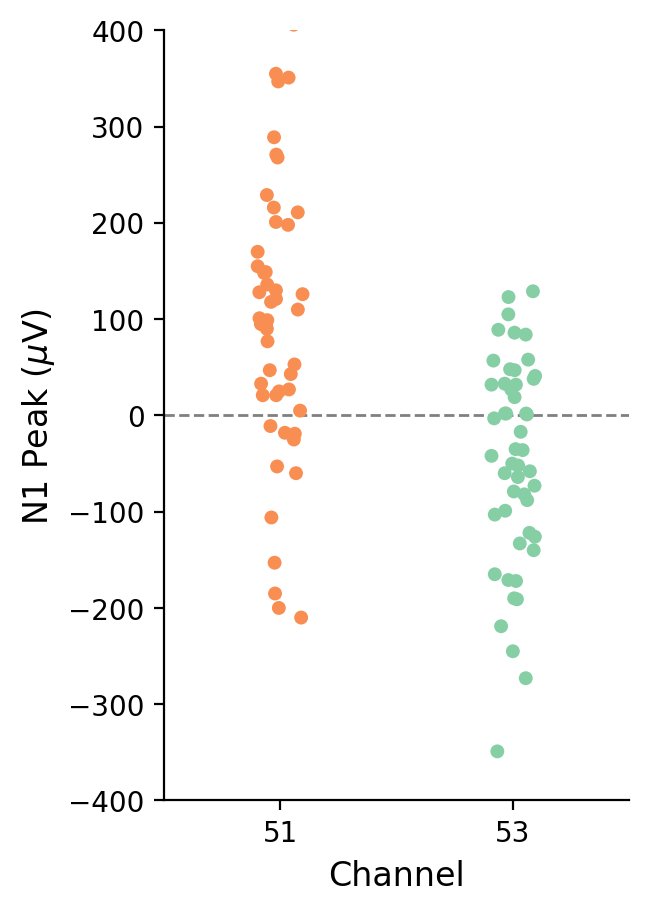

In [ ]:
# Figure parameters
fig, axes = plt.subplots(1, 1, figsize = (3,5))

# Create plot
sns.stripplot(x = 'Chan', y = 'N1', data = N1_DF, palette = [palette[chan51_idx], palette[chan53_idx]])

# Clean-up figure appearance
plt.axhline(0, linestyle = '--', linewidth = 1, color = 'grey')
plt.ylabel('N1 Peak ($\mu$V)', fontsize = 'large')
plt.xlabel('Channel', fontsize = 'large')
plt.ylim([-400, 400])
sns.despine(top = True, right = True)

plt.show()

Finally, we can can perform a statistical test to determine whether there exists a significant difference in the N1 peaks between two channels. Since we have two unrelated groups and one dependent variable, we will use a *independent-samples t-test*. To do so, we'll use the [`scipy.stats.ttest_ind`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) function.

In [ ]:
# Takes two inputs: values for Chan51 and values for Chan53
t,p = ttest_ind(N1_DF[N1_DF['Chan'] == 51]['N1'], N1_DF[N1_DF['Chan'] == 53]['N1'])
df = N1_DF.shape[0] - 2

# Print result in standard format
if p < 0.001:
  print('t(%s) = %.2f, p < 0.001' %(df, t))
elif p < 0.01:
  print('t(%s) = %.2f, p < 0.01' %(df, t))
elif p < 0.05:
  print('t(%s) = %.2f, p < 0.05' %(df, t))
else:
  print('t(%s) = %.2f, p = %f (NOT SIGNIFICANT)' %(df, t, p))

t(98) = 5.65, p < 0.001


Our results indicate that there is definitely a *significant* difference between the N1 peaks of channels 51 & 53!

# Do It Yourself (DIY):

Previously, I performed some event-related analyses to characterize how CCEPs propagate throughout the brain. To do so, I extracted a meaningful feature in the CCEP (i.e., *Max Descent*), and investigated whether this feature was linearly related to the distance between the electrode being stimulated and the electrode where the CCEP was recorded. We observed interesting spectrotemporal dynamics of CCEP propagation, namely, that many CCEPs appear to propagate as *traveling waves*. You can read more about the motivation for the study, as well as the results [here](https://www.biorxiv.org/content/10.1101/2023.03.27.534002v1). Below is one of the figures from the manuscript (i.e., Fig 2) which illustrates the detection and analysis of traveling waves.


<br>

<img src='https://drive.google.com/uc?id=1lIGGKp46faybBSijPWvluhWmg7wRneNZ'>

----

> **A.** Example CCEP evoked by single-pulse electrical stimulation. **B.** Subset of CCEPs with amplitude max descents marked. Stimulation at this location evoked robust CCEPs in several other electrodes, some of which are highlighted to show variability in max descent time (indicated with a circle and dotted line). **C.** Example traveling wave. The distance (Euclidean shown) between electrodes was linearly regressed onto max descent time to identify traveling waves. Dots represent electrodes with robust CCEPs, colored by time to max descent (green → blue, early → late). The shaded area represents 95% CI. Brain image shows the location of contacts in the model. **D.** Example 1,000-fold permutation test comparing linear model t-values against a null distribution.  

<br>

In this DIY part of the tutorial, you'll be tasked with replicating some of the results I reported in the manuscript. To this end, we'll use a small sample of the dataset to identify whether stimulation of different electrodes generated CCEPs that propagated as traveling waves.   

Rather than storing the raw CCEP data, `CCEPTWDataset.csv` contains some features that were calculated previously; only channels with robust CCEPs are included. The dataset has the following columns:
- `stimlevel`: stimulation amplitude (uA)
- `stimchan`: stimulation channel
- `respchan`: response channel
- `euc_dst`: Euclidean distance between `stimchan` and `respchan` (mm)
- `maxDescent`: Trial-averaged max descent (uV)
- `maxDescenTime`: Trial-averaged max descent time (ms)
- `N1Peak`: Trial-averaged N1 peak (uV)
- `N1PeakTime`: Trial-averaged N1 peak time (ms)

## Apply what you've learned in the tutorial to do the following:

1. Describe the dataset by calculating:
  - Number of channels stimulated
  - Number of channels with robust CCEPs
  - Mean ± SD for `euc_dst`, `maxDescent`, `maxDescentTime`, `N1Peak`, `N1PeakTime`
2. Create a variable which records each of the `respchans` for a given `stimchan` (e.g., 1: 2, 3, 4...)
3. Use the `plotTW()` function to visualize CCEP propagation and determine whether channels 1-5 evoked traveling waves (p < 0.05).
4. Draft a brief summary of the methods used and your observations.

#### Helpful function
- `plotTW()`: linearly regresses the Euclidean distances between a stim contact and the response contact(s) where robust CCEPs were recorded onto their respective max descent timings to identify traveling waves. **Takes `stimchan` as an argument**.

In [ ]:
def plotTW(stimchan):
  '''
  plotTW() linearly regresses the Euclidean distances between a stim contact and
  the response contact(s) where robust CCEPs were recorded onto their respective
  max descent timings to identify traveling waves.

  Arguments:
    - stimchan (int): channel stimulated

  Returns:
    - Figure
  '''

  # Subset data
  stimchan = stimchan
  df = CCEP_TW_data.copy()
  df = df[df['stimchan'] == stimchan]
  dfs = len(df) - 2

  # Fit OLS Model
  X = df['euc_dst']
  Y = df['maxDescentTime']
  X = sm.add_constant(X) # adding a constant
  model = sm.OLS(Y, X).fit()
  predictions = model.predict(X)

  # Get t-stat and p-value
  tVal = model.tvalues[1]
  pVal = model.pvalues[1]

  # Set legend to regression output
  regLabel = ['t(%.0f)' %dfs,' = %.2f,' %tVal, ' p = %.4f' %pVal]
  regLabel = ''.join(regLabel)
  regColor = [0.796501, 0.1050664, 0.3106303]

  # Generate plot
  sns.regplot(data = df, x = 'euc_dst', y = 'maxDescentTime', scatter = False)
  sns.scatterplot(x = 'euc_dst', y = 'maxDescentTime', data = df, hue = 'maxDescentTime', palette = 'crest', legend = False, zorder = 50)

  # Clean fig appearance
  plt.suptitle('Chan %s' %stimchan)
  plt.ylabel('Max Descent (ms)', fontsize = 'large')
  plt.xlabel('Euclidean Distance (mm)', fontsize = 'large')
  plt.xlim(df['euc_dst'].min()-1, df['euc_dst'].max()+1)
  plt.ylim(df['maxDescentTime'].min()-1, df['maxDescentTime'].max()+1)
  plt.legend(labels=[regLabel], title = '', bbox_to_anchor = (.5,1), fontsize = 'small', loc = 'lower center', frameon=True)
  fig = plt.gcf()
  fig.set_size_inches(5, 5)
  sns.despine(top = True, right = True)

  # Display
  plt.show()

#### Start Here:

In [ ]:
# Load and preview the CCEP TW dataset
CCEP_TW_data = pd.read_csv(os.path.join(datapath, 'CCEPTWDataset.csv'))
CCEP_TW_data

,stimlevel,stimchan,respchan,euc_dst,maxDescent,maxDescentTime,N1Peak,N1PeakTime
0,7500,1,2,5.000000,23.395770,30,66.870459,45
1,7500,1,3,9.998842,7.556446,36,56.084464,6
2,7500,1,4,14.997758,3.701329,37,26.252874,6
3,7500,1,9,38.347960,2.200085,68,-61.702558,34
4,7500,1,17,32.412791,5.118217,130,-42.288857,45
...,...,...,...,...,...,...,...,...
485,7500,94,90,19.989453,6.909396,25,-81.741269,45
486,7500,94,91,14.994216,9.426865,22,-56.445230,45
487,7500,94,92,9.998889,10.951872,21,61.601567,45
488,7500,94,95,5.000000,106.229332,22,-226.186308,42


In [ ]:
# Describe the dataset by summarizing features


In [ ]:
# Store respchans for each stimchan


In [ ]:
# Visualize TWs w/ plotTW()


#### Write-Up